## Filtering Clinical data for only high coverage samples

In [36]:
#load packages
library(ggplot2)
library(plyr)
library(tidyverse)
library(grid)
library(gridExtra)
library(ggrepel)
library(RColorBrewer)
library(glue)
library(cowplot)
library(UpSetR)
library(pheatmap)
library(vcfR)
library(igraph)
library(ggpubr)
library(readr)
library(VennDiagram)

In [2]:
# set folders
project_folder <- '/Users/roderae/National Institutes of Health/Ghedin, Elodie (NIH NIAID) [E] - LAB_STUFF/allison/projects/COV2-SNV'
mva_folder <- glue("{project_folder}/compare_callers/202204")
output_folder <- glue("{mva_folder}/062322_output")
code <- '/Users/roderae/National Institutes of Health/Ghedin, Elodie (NIH NIAID) [E] - LAB_STUFF/allison/code/SARS-CoV-2_analysis'

In [4]:
# source necessary scripts
source(glue("{code}/cov_aalist.R"))
source(glue("{code}/repsnv.R"))

In [30]:
# set color palettes
tool_colors <- c('#CC2F42', # freebayes - red
                 '#35B6E9', # hc - bright blue
                 '#009E73', # ivar - green
                 '#F9BECD', # lofreq - pink
                 '#F0E442', # mutect2 - yellow
                 '#CCD2EB', # timo - light purple
                 '#8DA1E2', # timo-no-binom - darker purple
                 '#9B9E9A', # varscan - grey
                 '#555555') # varscan, custom1 - darker grey
cat_colors <- c('#2F142B', # TP - dark purple
                '#F2A07B', # FP - peach
                '#5A7A96') # FN - blue
cov_af_colors <- c('#DDDDDD', # 100X - lightest grey
                '#BBBBBB', # 200X
                '#999999', # 300X
                '#777777', # 500X
                '#555555', # 1000X
                '#333333', # 10000X
                '#111111') # 100000X - darkest grey
virus_colors <- c('#2F142B', # H1N1 - dark purple
                  '#F2A07B', # H3N2 - peach
                  '#43668B', # VICT - blue
                  '#8DA1E2') # SARS - light purple

In [10]:
SEGMENTS = c('SARS-CoV2')
# Here we set the coverage cutoff to 5 for identification of consensus changes and the coverage cutoff to 200 for
# identification of minority variants
covcutoff = 5
minorcov = 200
# The initial allele frequency is set to .5%
minfreq = 0.03
# we exclude any instances were an 'N' is called in these analyses
ntlist = c('A','G','T','C')
orf1 <- c('nsp1','nsp2','nsp3','nsp4','nsp5',
          'nsp6','nsp7','nsp8','nsp9','nsp10',
          'nsp11','nsp12a','nsp12b','nsp13',
          'nsp14','nsp15','nsp16')

While simulated and synthetic data allow for testing minority variant callers and cutoffs in a controlled setting, real data will always be more unpredictable. Thus, after using simulated and synthetic data to assess variant caller performance across frequencies and coverages, we wanted to test how the callers performed on real SARS-CoV-2 sequence data. We used a modified version of the ARTIC protocol to sequence 73 low Ct SARS-CoV-2 samples in duplicate (Fig. S10A).

In [11]:
# run coverage script to get mean coverage, % coverage > 5X, and % coverage % 200X
setwd('/Users/roderae/National Institutes of Health/Ghedin, Elodie (NIH NIAID) [E] - LAB_STUFF/allison/projects/COV2-SNV/clinical_data')
rep1cov = cov_aalist(input = "./rep1/aasnplist", covcutoff = covcutoff, snvcutoff = minorcov)
rep2cov = cov_aalist(input = "./rep2/aasnplist", covcutoff = covcutoff, snvcutoff = minorcov)

Warning message:
“package ‘writexl’ was built under R version 4.0.2”


In [12]:
# adjust sampleIDs for easy filtering
rep1cov <- rep1cov %>% separate(name, into = c("MD","NIH","code","rep"), sep = '-') %>% select(-c(MD, NIH))
rep2cov <- rep2cov %>% separate(name, into = c("MD","NIH","code","rep"), sep = '-') %>% select(-c(MD, NIH))

rep1cov$code <- gsub("00","",rep1cov$code)
rep2cov$code <- gsub("00","",rep2cov$code)

In [13]:
# load in metadata - sample collection dates, Ct values and ddPCR values
metadata <- read.csv(file = "metadata.csv")
metadata$code <- gsub("MD-NIH-00","",metadata$code)

In [14]:
# display metadata
metadata

code,type,collection_date,Ct,ddPCR
<chr>,<chr>,<chr>,<dbl>,<dbl>
013,NP SWAB,2020-07-24,17.40,75322.67
016,NP SWAB,2020-07-31,15.20,57802.11
017,MT SWAB,2020-08-08,16.60,88244.78
019,NP SWAB,2020-08-10,20.10,78712.14
020,NP SWAB,2020-08-17,20.60,63570.72
027,NP SWAB,2020-09-18,23.30,6588.35
031,NP SWAB,2020-10-20,20.20,73335.75
038,NP SWAB,2020-11-02,17.70,60422.39
069,MT SWAB,2020-12-11,19.10,732318.95


In [15]:
# merge the files by source_ID, ddPCR and Ct value - these will be the same for both replicates
cov_merge <- merge(rep1cov, rep2cov, by=c("code"), all.x=T, all.y=T)

# change column names
names(cov_merge)[names(cov_merge) == 'percent-con-coverage.x'] <- "con.rep1"
names(cov_merge)[names(cov_merge) == 'percent-con-coverage.y'] <- "con.rep2"

names(cov_merge)[names(cov_merge) == 'percent-coverage-snvcoverage.x'] <- "snv.rep1"
names(cov_merge)[names(cov_merge) == 'percent-coverage-snvcoverage.y'] <- "snv.rep2"

names(cov_merge)[names(cov_merge) == 'mean-coverage.x'] <- "meancov.rep1"
names(cov_merge)[names(cov_merge) == 'mean-coverage.y'] <- "meancov.rep2"

# select necessary columns
cov_merge <- cov_merge %>% select(-c(rep.x, rep.y)) %>% 
                            select(code, con.rep1, con.rep2, snv.rep1, snv.rep2, meancov.rep1, meancov.rep2)

cov_merge <- merge(cov_merge, metadata, by=c("code"), all.x = T)

# change columns to numerical values for plotting
cov_merge$con.rep1 <- as.numeric(cov_merge$con.rep1)
cov_merge$con.rep2 <- as.numeric(cov_merge$con.rep2)
cov_merge$snv.rep1 <- as.numeric(cov_merge$snv.rep1)
cov_merge$snv.rep2 <- as.numeric(cov_merge$snv.rep2)
cov_merge$meancov.rep1 <- as.numeric(cov_merge$meancov.rep1)
cov_merge$meancov.rep2 <- as.numeric(cov_merge$meancov.rep2)

In [37]:
write_excel_csv(cov_merge, file = glue("{output_folder}/metadata_coverage.csv"))

In [31]:
# plot Ct Value against percent of genome covered at 5x or 200x
options(repr.plot.width=3.5, repr.plot.height=3)

plot1 = cov_merge %>%
          ggplot +
            geom_point(aes(x=Ct, y=con.rep1), color = '#070307', size=2, alpha=0.8, shape='square') +
            geom_point(aes(x=Ct, y=con.rep2), color = '#427299', size=2, alpha=0.8, shape='circle') +
          scale_x_reverse(name="Ct value") +
          scale_y_continuous(name = "% of genome with >= 5x coverage",
                            limits=c(0,100)) +
          theme_bw()


plot2 = cov_merge %>%
          ggplot +
            geom_point(aes(x=Ct, y=snv.rep1), color = '#070307', size=2, alpha=0.8, shape='square') +
            geom_point(aes(x=Ct, y=snv.rep2), color = '#427299', size=2, alpha=0.8, shape='circle') +
          scale_x_reverse(name="Ct value") +
          scale_y_continuous(name = "% of genome with >= 200x coverage",
                            limits=c(0,100)) +
          theme_bw()

ggsave(plot1, filename = "covplot.5x.pdf",
    path=output_folder, width = 3.5, height = 3, limitsize=FALSE, useDingbats =FALSE)
ggsave(plot2, filename = "covplot.200x.pdf",
    path=output_folder, width = 3.5, height = 3, limitsize=FALSE, useDingbats =FALSE)

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


#### Figure S10A:

Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


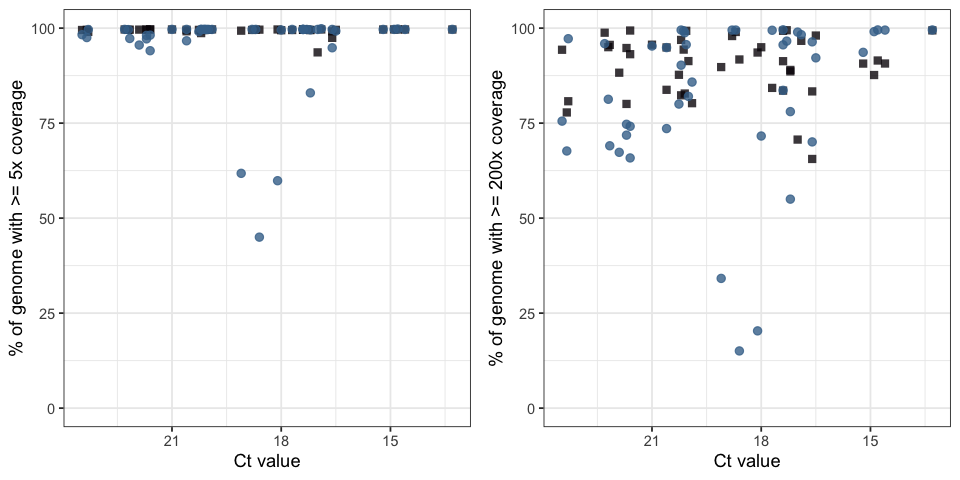

In [32]:
options(repr.plot.width=8, repr.plot.height=4)
ggarrange(plot1, plot2, nrow = 1, ncol = 2)

Based on the simulated and synthetic data testing, we determined that a coverage cutoff of 200X and an allele frequency cutoff of 0.03 in single replicate data, minimized false positive calls without sacrificing large amounts of true positive data with most variant calling tools. To test the variant calling tools on only high-quality data, we filtered for samples where at least 80% of the genome had a read depth over 200x coverage cutoff in both sequencing replicates.

In [18]:
# extract rows where both replicates have over 90% coverage
highcov <- cov_merge %>% filter(snv.rep1 > 80 & snv.rep2 > 80 & Ct <= 28)

In [33]:
# plot coverage against Ct for only samples where both replicates have over 90% coverage
options(repr.plot.width=3.5, repr.plot.height=3)

plot3 = highcov %>%
          ggplot +
            geom_point(aes(x=Ct, y=con.rep1), color = '#070307', size=2, alpha=0.8, shape='square') +
            geom_point(aes(x=Ct, y=con.rep2), color = '#427299', size=2, alpha=0.8, shape='circle') +
          scale_x_reverse(name="Ct value") +
                            #breaks=c(seq(0,550,by=50))) +
          scale_y_continuous(name = "% of genome with >= 5x coverage",
                            limits=c(0,100)) +
          theme_bw()

#copies/mL vs. coverage all data
plot4 = highcov %>%
          ggplot +
            geom_point(aes(x=Ct, y=snv.rep1), color = '#070307', size=2, alpha=0.8, shape='square') +
            geom_point(aes(x=Ct, y=snv.rep2), color = '#427299', size=2, alpha=0.8, shape='circle') +
          scale_x_reverse(name="Ct value") +
                            #breaks=c(seq(0,550,by=50))) +
          scale_y_continuous(name = "% of genome with >= 200x coverage",
                            limits=c(0,100)) +
          theme_bw()

ggsave(plot3, filename = "highcovplot.5x.pdf",
    path=output_folder, width = 3.5, height = 3, limitsize=FALSE, useDingbats =FALSE)
ggsave(plot4, filename = "highcovplot.200x.pdf",
    path=output_folder, width = 3.5, height = 3, limitsize=FALSE, useDingbats =FALSE)

#### Figure S10B:

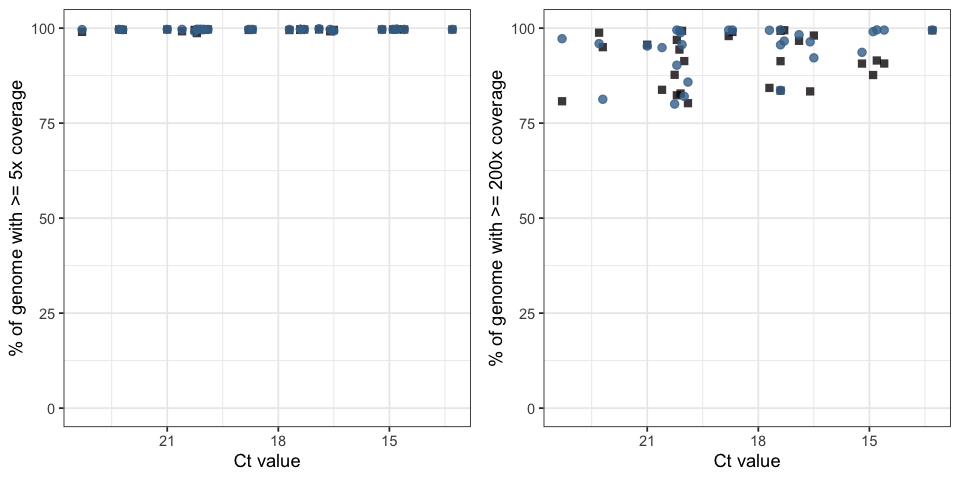

In [34]:
options(repr.plot.width=8, repr.plot.height=4)
ggarrange(plot3, plot4, nrow = 1, ncol = 2)

This filtering narrowed the data set to 28 high quality samples for analysis (Fig. S10B).

In [35]:
# get number of samples with 80% of the genome over 200X
length(unique(highcov$code))

[1] 28

In [27]:
write_excel_csv(highcov, file = glue("{mva_folder}/highcov.samples.csv"))